# Get started with MultiVae

In this tutorial we detail an example on how to define train and evaluate a model with MultiVae.

## Load dataset

As a simple example here (and to allow easy training), we load the MnistAttribute dataset from the library.

In [ ]:
from multivae.data.datasets.mnist_labels import BinaryMnistLabels

dataset = BinaryMnistLabels('~/scratch/data', 'test',download=True)

: 

The modalities in that dataset are named ['images', 'labels']
The text attribute for this image is tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]])


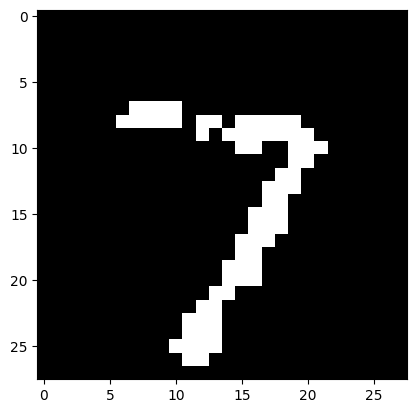

In [2]:
# visualize one sample
import matplotlib.pyplot as plt
sample = dataset[0]

# A sample contains a field 'data' with the data for both modalities (here images and labels) and eventual additional fields (labels, masks..)
print(f'The modalities in that dataset are named {list(sample.data.keys())}')

plt.imshow(sample.data['images'][0], cmap='gray')
print(f'The text attribute for this image is {sample.data["labels"]}')


## Create a model 

In [3]:
# Import the model of your choice
from multivae.models import MVTCAE, MVTCAEConfig

In [4]:
# Define the model configuration

model_config = MVTCAEConfig(
    n_modalities=2,
    latent_dim=20,
    input_dims= {'images' : (1,28,28), 'labels' : (1,10)},
    decoders_dist= {'images' : 'normal', 'labels' : 'categorical'},
    
    alpha=2./3.,
    beta=2.5,
    
    uses_likelihood_rescaling=True,
    rescale_factors=dict(images=1, labels=50)
)

In [5]:
# Initialize the model

# If no encoders/ decoders architectures are specified, default MLPs are used
model = MVTCAE(model_config = model_config)

In [6]:
# check that everything works
model(dataset[:10])

ModelOutput([('loss', tensor(628.6888, grad_fn=<DivBackward0>)),
             ('metrics',
              {'joint_divergence': tensor(19.8780, grad_fn=<MulBackward0>),
               'images': tensor(8195.0684, grad_fn=<SumBackward0>),
               'labels': tensor(1160.0559, grad_fn=<SumBackward0>),
               'kld_images': tensor(21.4488, grad_fn=<SumBackward0>),
               'kld_labels': tensor(18.8400, grad_fn=<SumBackward0>)})])

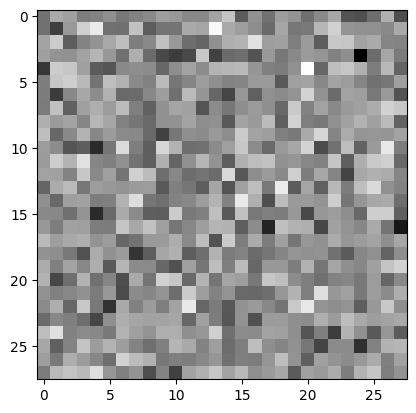

In [7]:
# Predict before training

from multivae.data import MultimodalBaseDataset
model.eval()
data = model.predict(
    inputs=dataset[0],
    cond_mod='labels',
)


plt.imshow(data['images'][0][0], cmap='gray')

## Using custom architectures

You can use custom architectures with any modalities and for each modality. 
Below we define two simple convolutional architecture that can be used to encode the MNIST images. 

In [8]:
from multivae.models.base import BaseEncoder, BaseDecoder, ModelOutput
import torch

# The custom encoder must be an instance of the BaseEncoder class
class ImageEncoder(BaseEncoder):
    
    "A simple custom convolutional architecture to use on MNIST images."
    
    def __init__(self):
        super().__init__()
        self.latent_dim = 20 
        
        self.conv_net = torch.nn.Sequential(
            torch.nn.Conv2d(1, 8, 3, stride=2, padding=1),
            torch.nn.ReLU(True),
            torch.nn.Conv2d(8, 16, 3, stride=2, padding=1),
            torch.nn.ReLU(True),
            torch.nn.Conv2d(16, 32, 3, stride=2, padding=0),
            torch.nn.ReLU(True),
            torch.nn.Flatten(start_dim=1)
        )
        

        self.embedding_layer = torch.nn.Sequential(
            torch.nn.Linear(3 * 3 * 32, self.latent_dim)
        )
        self.covariance_layer = torch.nn.Sequential(
            torch.nn.Linear(3 * 3 * 32, self.latent_dim)
        )
        
    def forward(self, x):
        h = self.conv_net(x)
        
        #### The output of the variational encoder must be a ModelOutput instance 
        #### with an embedding field and log_covariance field
        
        return ModelOutput(
            embedding = self.embedding_layer(h),
            log_covariance = self.covariance_layer(h)
        )
    
# The custom decoder must be an instance of the BaseDecoder class
class ImageDecoder(BaseDecoder):
    
    def __init__(self):
        
        super().__init__()
        self.linear = torch.nn.Sequential(
            torch.nn.Linear(20, 3*3*32),
            torch.nn.ReLU(True),
            torch.nn.Unflatten(dim=1,
            unflattened_size=(32, 3, 3))
        )


        self.conv_net = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(32, 16, 3, 
            stride=2, output_padding=0),
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d(16, 8, 3, stride=2, 
            padding=1, output_padding=1),
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d(8, 1, 3, stride=2, 
            padding=1, output_padding=1),
            
        )
        
    def forward(self, x):
        h = self.linear(x)
        h = self.conv_net(h)
        x = torch.sigmoid(h)
        
        #### The output must be a ModelOutput instance with a 'reconstruction' field
        return ModelOutput(reconstruction = x)
    
    

Here we instantiate a model with custom architectures provided. Note that for the labels, we use the same architectures that are provided by default when 'encoders = None' or 'decoders = None'.

In [9]:
from multivae.models.nn.default_architectures import Encoder_VAE_MLP, Decoder_AE_MLP, BaseAEConfig

label_encoder = Encoder_VAE_MLP(BaseAEConfig(input_dim = (10,), latent_dim=20))
label_decoder = Decoder_AE_MLP(BaseAEConfig(input_dim=(10,), latent_dim=20))

model_custom = MVTCAE(model_config=model_config,
               encoders = dict(images = ImageEncoder(), labels=label_encoder),
               decoders=dict(images = ImageDecoder(), labels=label_decoder))

## Training

In [10]:
from multivae.trainers import BaseTrainer, BaseTrainerConfig

trainer_config = BaseTrainerConfig(
    num_epochs=1,
    learning_rate=1e-2,
    
)

trainer = BaseTrainer(
    model=model,
    training_config=trainer_config,
    train_dataset=dataset
    )

trainer.train()

! No eval dataset provided ! -> keeping best model on train.

Model passed sanity check !
Ready for training.

Setting the optimizer with learning rate 0.01
Created dummy_output_dir/MVTCAE_training_2023-05-28_15-24-56. 
Training config, checkpoints and final model will be saved here.

Training params:
 - max_epochs: 1
 - per_device_train_batch_size: 64
 - per_device_eval_batch_size: 64
 - checkpoint saving every: None
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.01
    maximize: False
    weight_decay: 0
)
Scheduler: None

Successfully launched training !

Training of epoch 1/1: 100%|██████████| 157/157 [00:04<00:00, 34.30batch/s]
--------------------------------------------------------------------------
Train loss: 562.0554
--------------------------------------------------------------------------
Training ended!
Saved final model in dummy_outpu

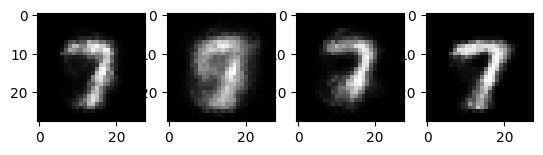

In [11]:
# Predict after training

from multivae.data import MultimodalBaseDataset

# images from label : show a few samples 
data = model.predict(
    inputs=dataset[0],
    cond_mod='labels',
    N = 4,
)

fig, ax = plt.subplots(1,4)
for i in range(4):
    ax[i].imshow(data['images'][i][0][0], cmap='gray')

## Computing metrics

In [12]:
from multivae.metrics.likelihoods import LikelihoodsEvaluator, LikelihoodsEvaluatorConfig

ll_config = LikelihoodsEvaluatorConfig(
    batch_size=128,
    num_samples=100)

ll = LikelihoodsEvaluator(
    model,dataset,eval_config=ll_config
)

ll.eval()

100%|██████████| 79/79 [00:58<00:00,  1.36it/s]
Joint likelihood : tensor(753.3777)


ModelOutput([('joint_likelihood', tensor(753.3777))])